In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys
import astropy.units as units
import pandas as pd
import lightkurve as lk
import importlib


In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.05]
teff = [4750, 100]
bp_rp = [1.34, 0.1]

In [3]:
lc = lk.search_lightcurvefile(kic, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
for q in range(2,17):
    lc = lc.append(lk.search_lightcurvefile(kic, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401))


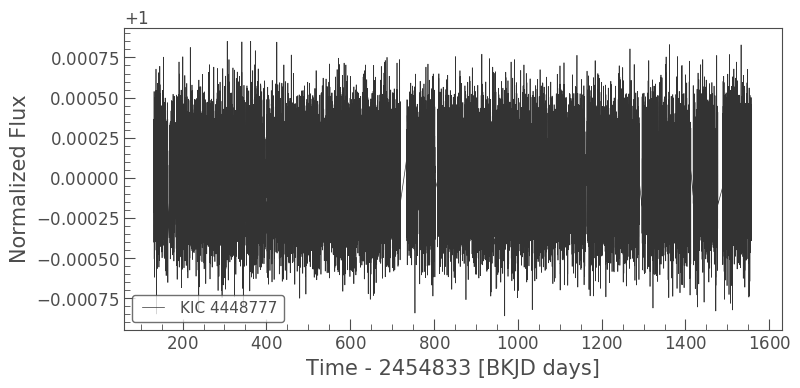

In [4]:
lc = lc.remove_outliers(4)
lc.plot()

In [5]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=150.0).flatten()

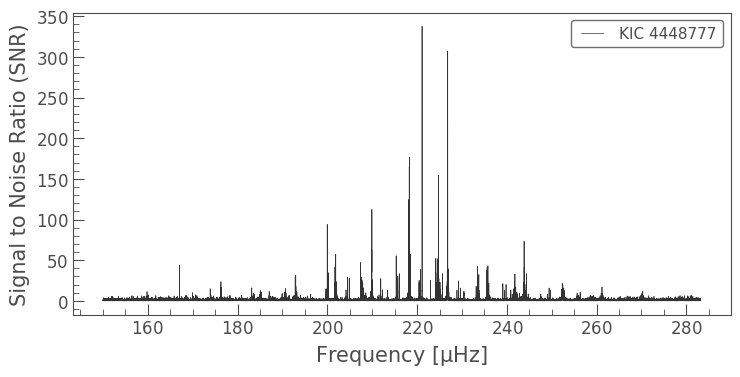

In [6]:
pg.plot()

In [7]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp, bw_fac=1.0)

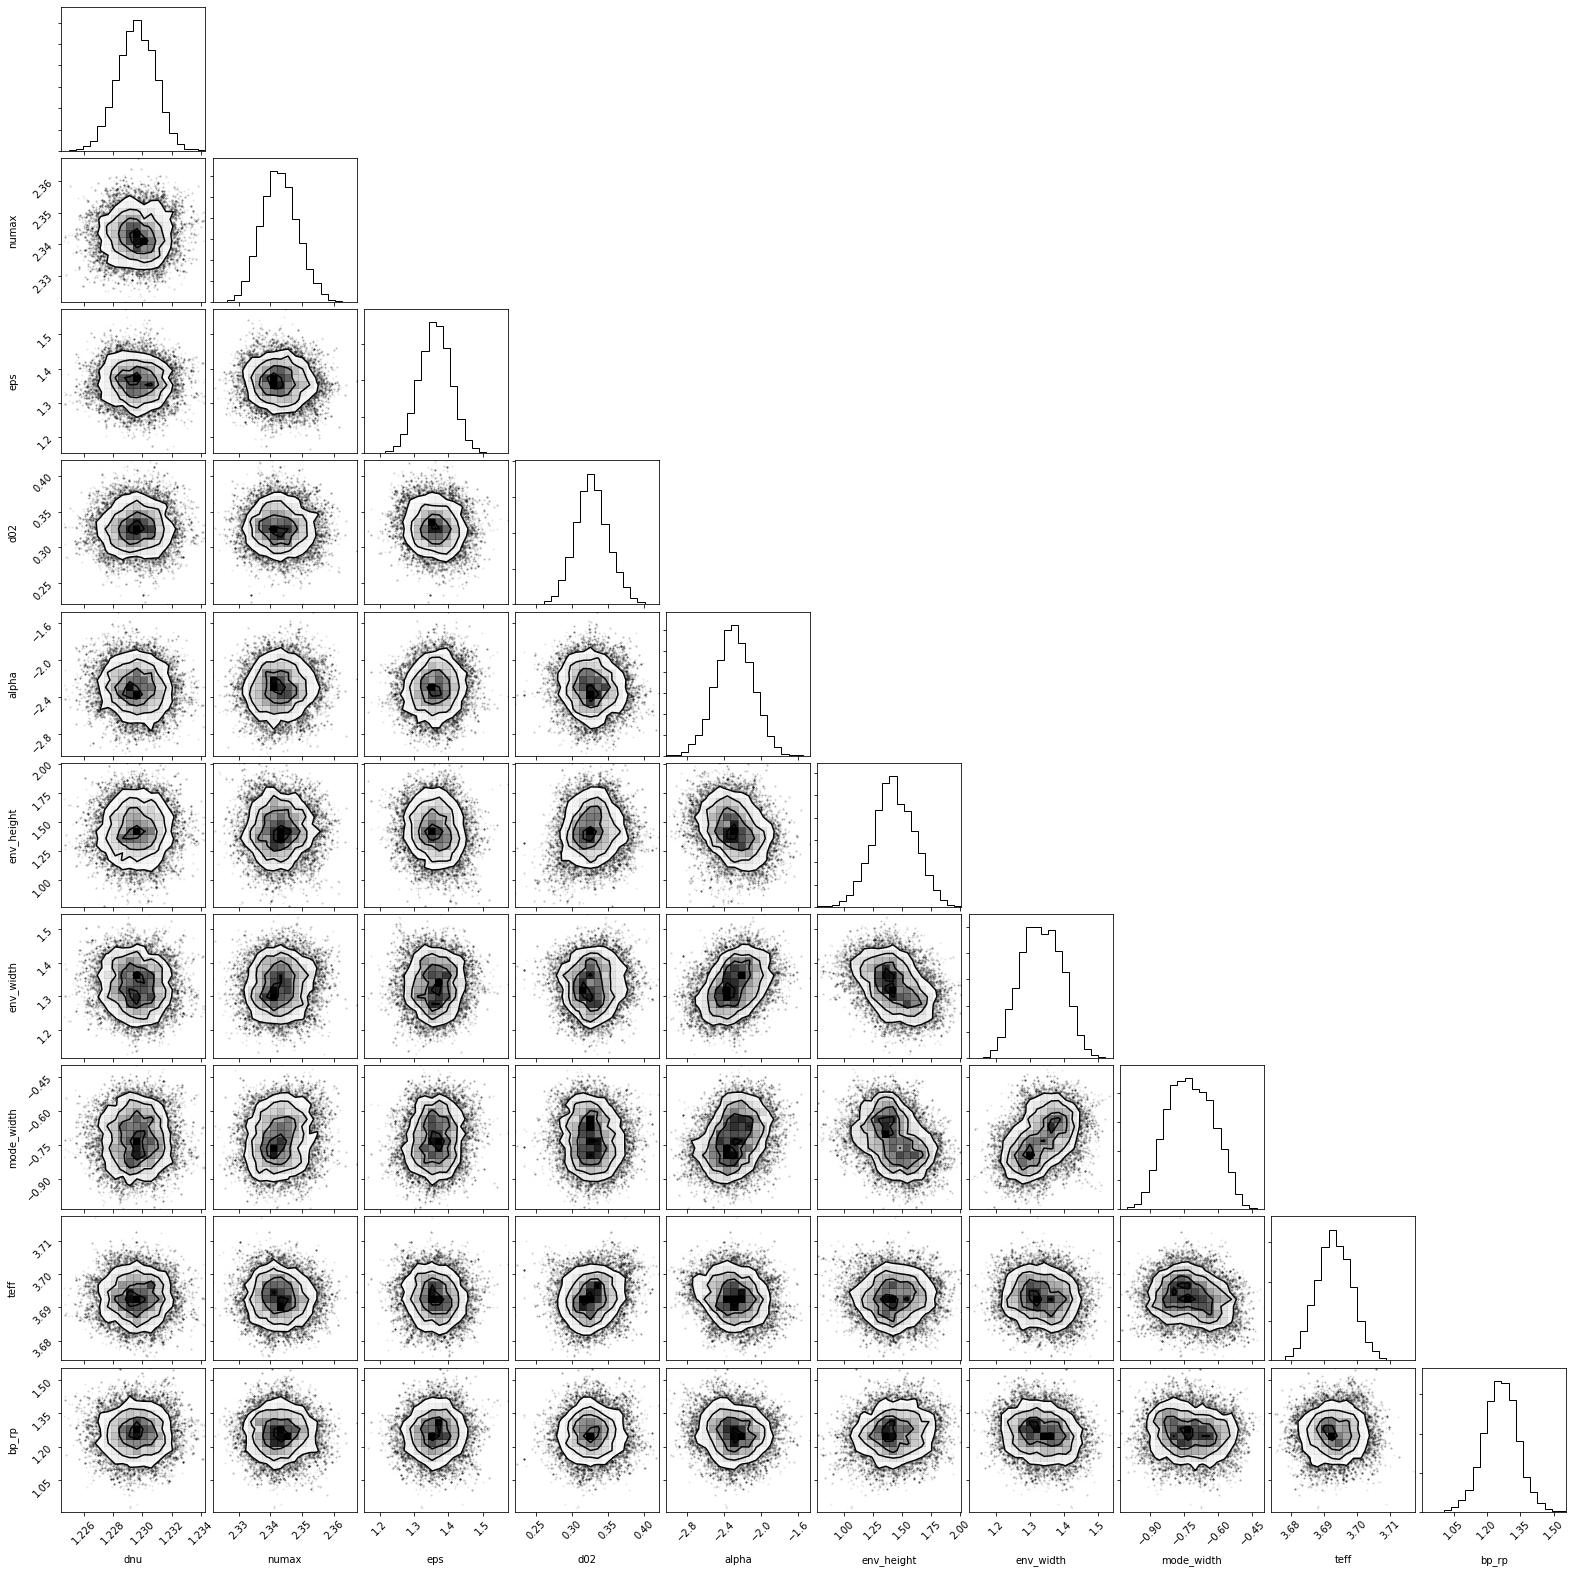

In [8]:
import corner
corner.corner(ep.samples, labels=ep.cols);

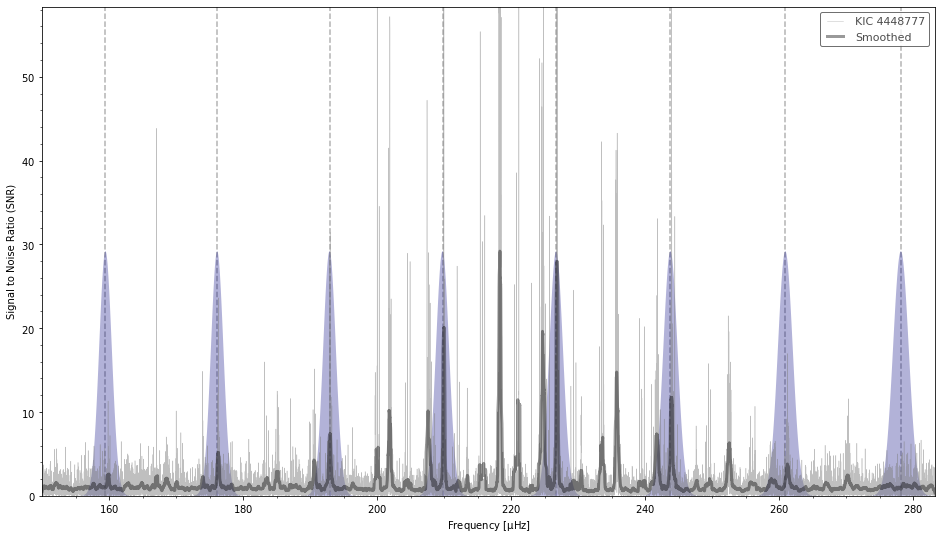

In [9]:
ep.plot(pg)

In [10]:
importlib.reload(pb.asy_peakbag)
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=4, norders=5,
                                    store_chains=True)

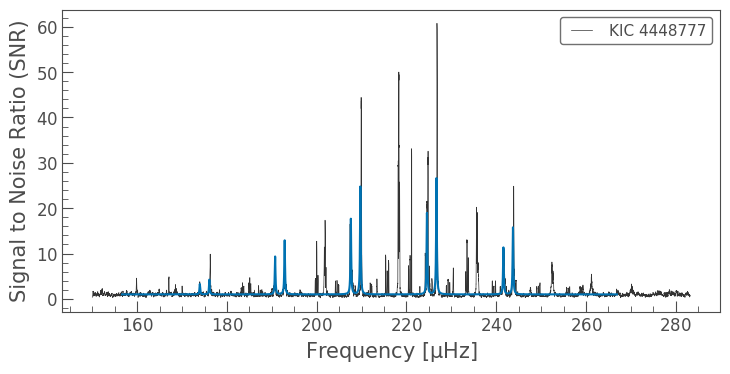

In [11]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.start))

In [12]:
asy_result = asy.run(burnin=1000, niter=1000)

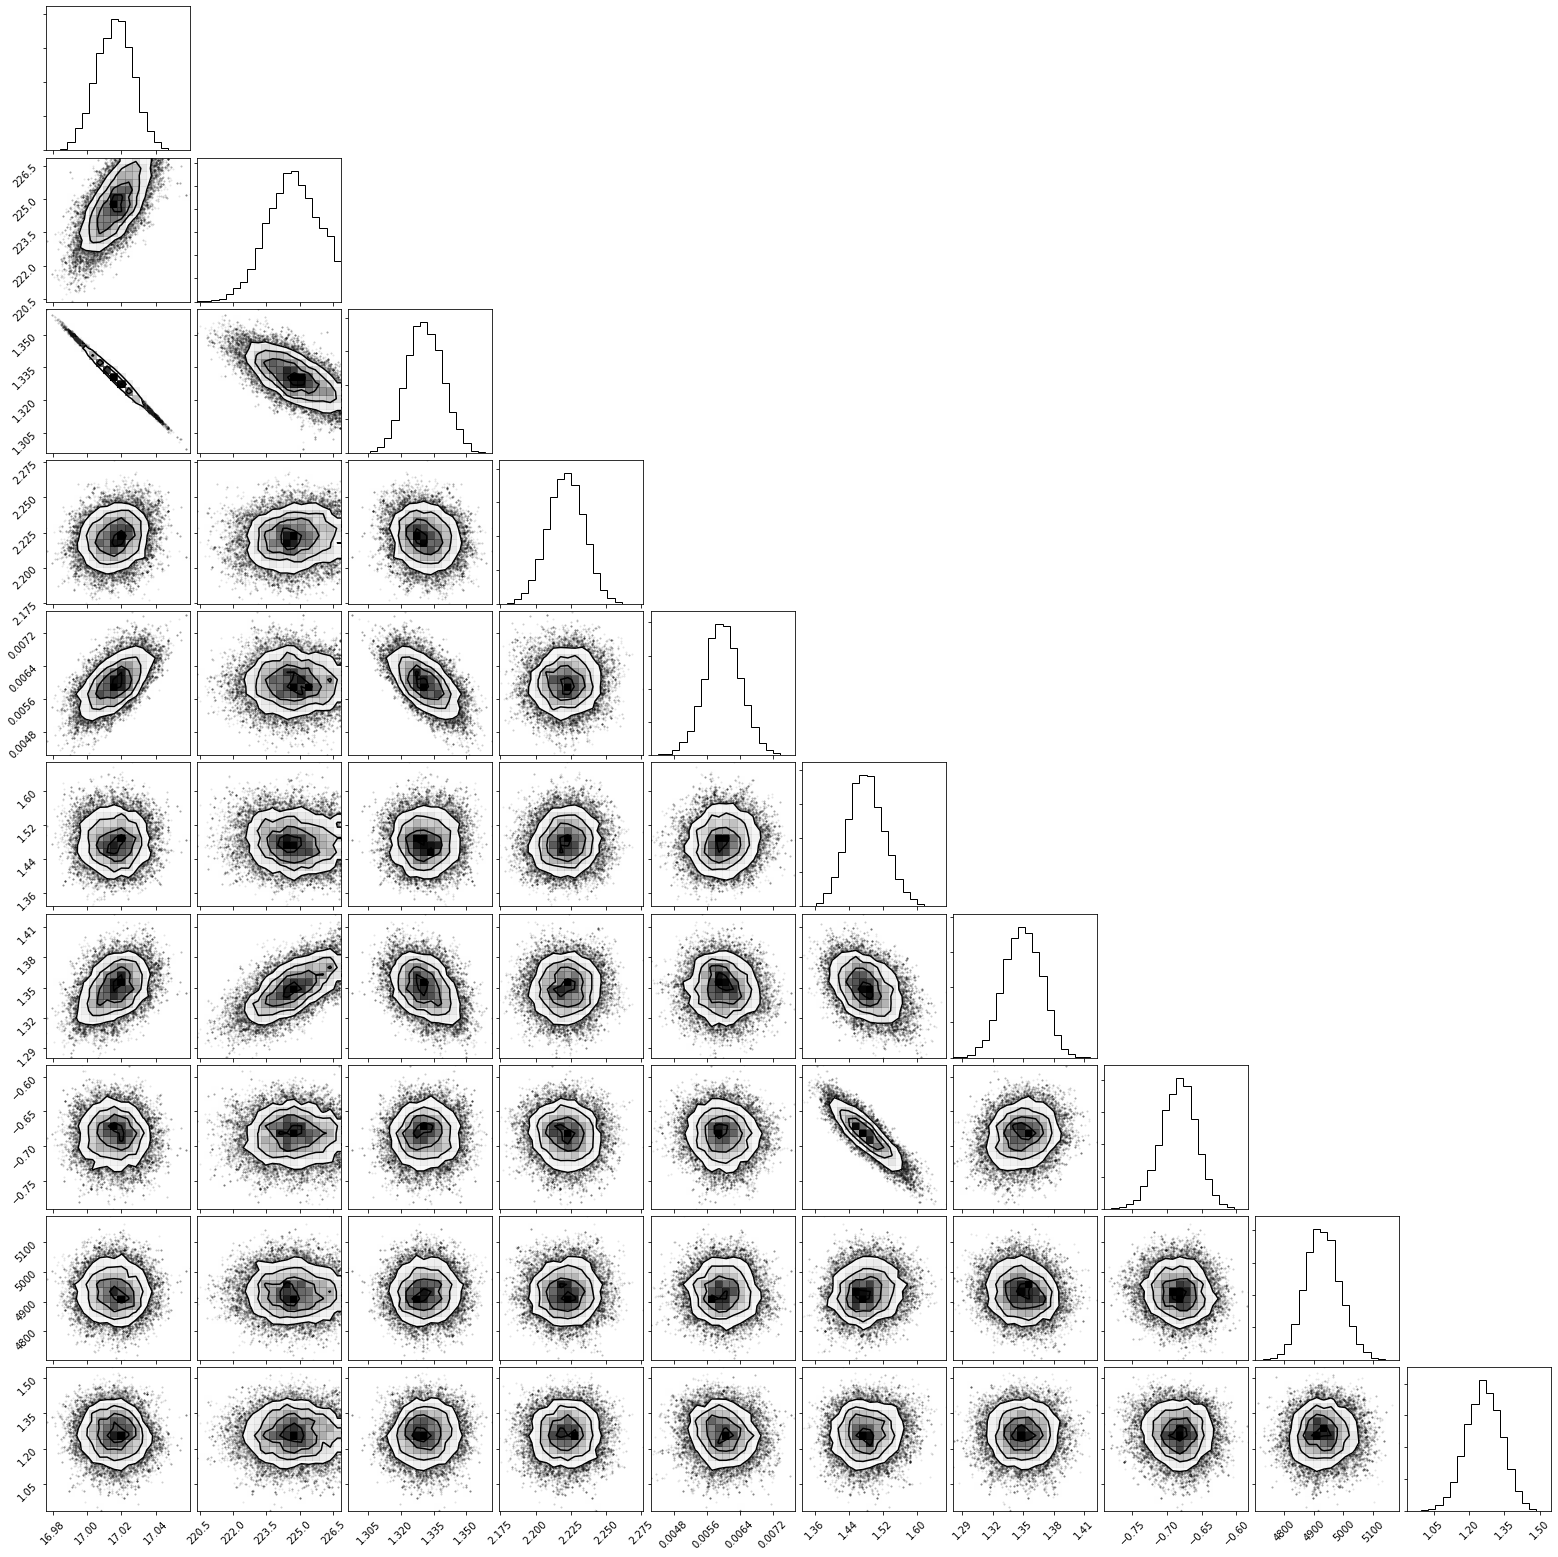

In [13]:
corner.corner(asy.flatchain);

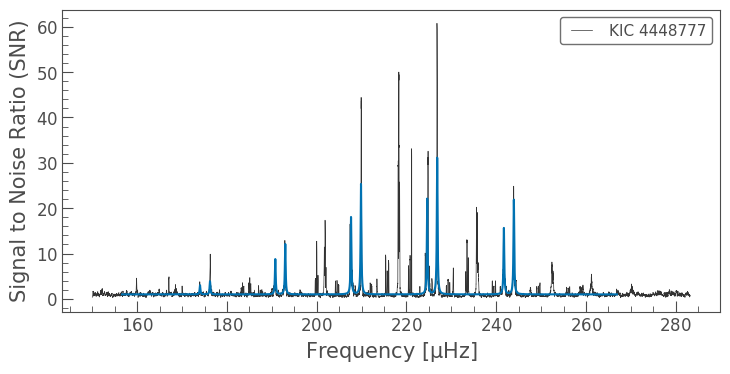

In [14]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.flatchain.mean(axis=0)))

In [15]:
asy_result['summary']

,dnu,numax,eps,d02,alpha,env_height,env_width,mode_width,teff,bp_rp
mle,17.020545,225.120346,1.327609,2.221211,0.005950,1.492959,1.352638,-0.694710,4934.961859,1.257428
mean,17.016076,224.663878,1.330982,2.221347,0.005987,1.480870,1.349391,-0.683736,4930.615536,1.262453
std,0.010510,1.109915,0.008151,0.012810,0.000437,0.042828,0.018297,0.025897,58.842794,0.075680
skew,-0.046362,-0.230253,0.045202,-0.049028,0.017115,0.187744,-0.048985,-0.144748,0.143860,-0.124510
2nd,16.994675,222.332700,1.314970,2.195372,0.005102,1.398699,1.312196,-0.737285,4817.983743,1.106938
16th,17.005290,223.518101,1.322776,2.208630,0.005564,1.438554,1.331079,-0.709320,4872.557904,1.186660
50th,17.016303,224.687352,1.330801,2.221458,0.005982,1.479180,1.349383,-0.682961,4928.510919,1.263288
84th,17.026618,225.863732,1.339241,2.234190,0.006423,1.524503,1.368283,-0.658392,4989.830895,1.338948
97th,17.036673,226.637362,1.347528,2.246512,0.006869,1.571030,1.384737,-0.633325,5052.150067,1.407674
MAD,0.010821,1.173185,0.008404,0.012854,0.000425,0.042864,0.018736,0.025498,57.936832,0.077721


In [16]:
import importlib
import pbjam

In [17]:
importlib.reload(pbjam)
pbag = pbjam.peakbag(pg.frequency.value, pg.power.value, asy_result)

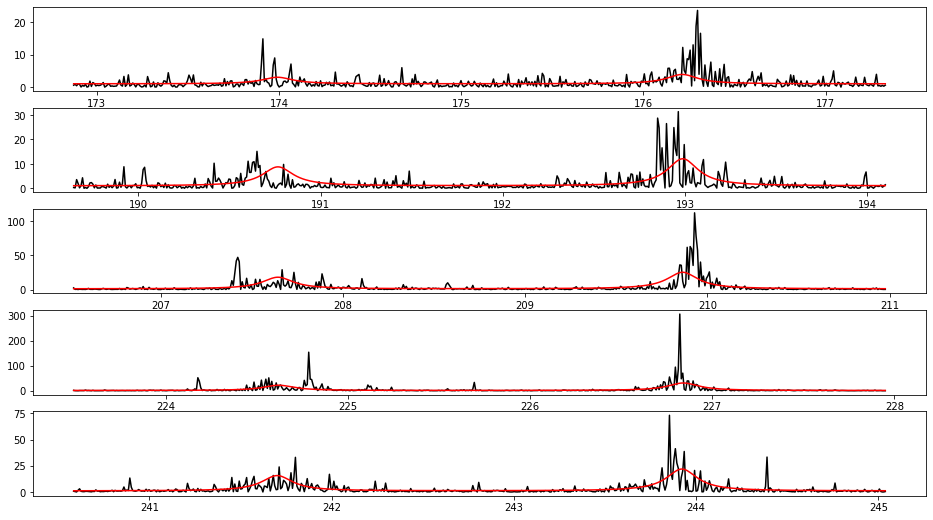

In [18]:
pbag.plot_start_model()

In [19]:
pbag.sample(model_type='simple', cores=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:17<00:00, 462.46draws/s]


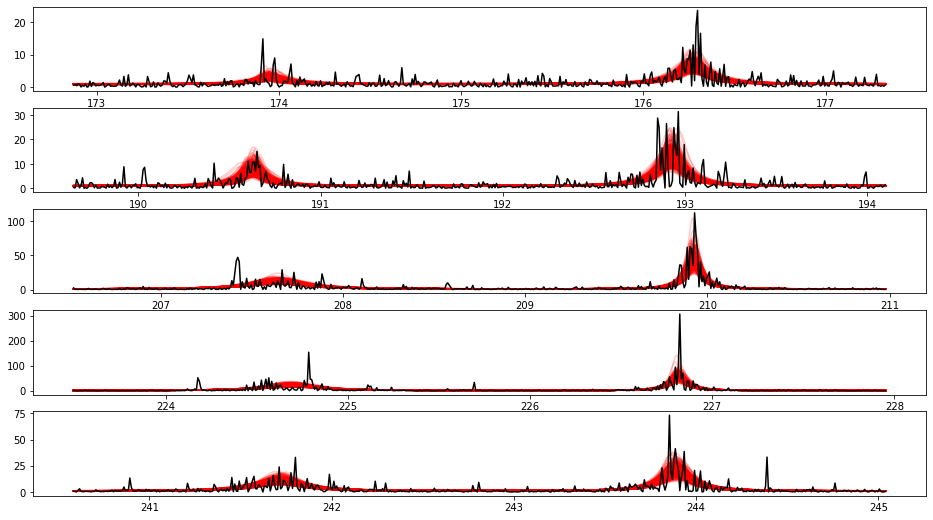

In [20]:
pbag.plot_fit(thin=1)

In [21]:
import pymc3 as pm
pm.summary(pbag.samples)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
l0__0,176.269812,0.017503,0.000318,176.235565,176.304624,3113.771031,0.999258
l0__1,192.924215,0.015807,0.000261,192.895516,192.956795,3797.172783,0.999389
l0__2,209.924341,0.008879,0.000142,209.906797,209.941892,4134.155982,0.999030
l0__3,226.814551,0.008686,0.000150,226.796072,226.830240,5107.719226,0.999599
l0__4,243.889927,0.016822,0.000269,243.856323,243.922305,3873.935052,0.999549
l2__0,173.954192,0.027471,0.000533,173.901058,174.006941,2999.778379,0.999249
l2__1,190.628598,0.017658,0.000293,190.592456,190.660698,3579.676614,0.999497
l2__2,207.640182,0.024405,0.000452,207.589326,207.684242,2976.223195,0.999481
l2__3,224.690282,0.019445,0.000272,224.651795,224.728292,5355.185318,0.999481
l2__4,241.715334,0.025217,0.000394,241.669664,241.770048,3582.013441,0.999266
